In [ ]:
%pip install pandas matplotlib scipy seaborn ipyfilechooser

In [60]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from dateutil import tz
import itertools

In [2]:
from scipy.signal import savgol_filter

from common import combine_csvs
import common

In [132]:
MEGAb_TO_b = 1e6
N_TCP = 'TCP'
N_UDP = 'UDP'
N_DOWN = 'Download'
N_UP = 'Upload'

N_STARLINK = 'Starlink'
N_STARLINK_KOEYE = 'Starlink Koeye'
N_HOME = 'Home'

COL_TRANSF_DIR = 'Transfer Direction'
COL_PROT_TYPE = 'Protocol and Type'

TCP_DOWN = 'TCP Down'
UDP_DOWN = 'UDP Down'
TCP_UP = 'TCP Up'
UDP_UP = 'UDP Up'
PROTOCOLS_MAP = {TCP_DOWN: "*down.*.csv", UDP_DOWN: "*down*udp*.csv", 
                 TCP_UP: "*up.*[!p].csv", UDP_UP: "*receive*.udp.csv"}

PROTOCOLS_SEP_MAP = {TCP_DOWN: [N_TCP, N_DOWN], UDP_DOWN: [N_UDP, N_DOWN], 
                 TCP_UP: [N_TCP, N_UP], UDP_UP: [N_UDP, N_UP]}

PROT_TYPE_ORDER = [f'{N_TCP} {N_HOME}', f'{N_TCP} {N_STARLINK}', f'{N_UDP} {N_HOME}', f'{N_UDP} {N_STARLINK}']

TEMP='Temp (°C)'
PRECIP='Precip. Amount (mm)'

JITTER = 'jitter_ms'
BANDWIDTH = 'bandwidth'


N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_PROTOCOL = 'Protocol'

OUTPUT_FOLDER = 'output/throughput'

In [146]:
plot_params = common.plot_params
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 300
matplotlib.rcParams.update(plot_params)

sns_params = common.sns_params
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 300
sns.set_theme()
sns.set_context("paper", rc=sns_params)
sns.set(rc=sns_params)

In [5]:
def convert_to_mb(df):
    # Converts to Megabits per second
    df.bits_per_second /= MEGAb_TO_b
    df.rename(columns={'bits_per_second': 'bandwidth'}, inplace=True)

In [6]:
def concat_df(src, pattern, keep=['bandwidth']):
    files = glob.glob(f"{src}/**/{pattern}", recursive=True)
    combined_df = combine_csvs(files)
    
    combined_df.index = pd.to_datetime(combined_df.index, unit='s')
    if keep == ['bandwidth'] or keep == 'all':
        convert_to_mb(combined_df)
    if keep != 'all':
        combined_df = combined_df[keep]
    return combined_df

In [7]:
def remove_first_measures(df, first=3):
    # Remove first {first} datapoints for each measurement
    # Take into account of software tool overhead
    diff_time = (df.index - df.reset_index().timestamp.shift())
    # Choose entries where previous time is less than an hour
    first_measure_map = diff_time < pd.Timedelta(5, unit='m')
    # Propagate to first three datapoints
    for i in range(1, first):
        first_measure_map = first_measure_map.eq(first_measure_map.shift(i))

    df_map = pd.DataFrame(columns=df.columns)
    for i, _ in enumerate(df.columns):
        df_map.iloc[:, i] = first_measure_map
    df_map['timestamp'] = df.index
    df_map.set_index('timestamp', inplace=True)
    filtered_df = df.where(df_map, -1) # Set to -1

    return filtered_df

In [122]:
def combine_reg(src, pattern, keep=['bandwidth'], first=3):
    regions_df = pd.DataFrame()
    for region in glob.glob(f"{src}/*"):
        combined_df = concat_df(region, pattern, keep).sort_values('timestamp')
        reg_name = os.path.basename(region)
        combined_df = remove_first_measures(combined_df, first)
        combined_df[N_REGIONS] = common.region_mapping[reg_name]

        if regions_df.empty:
            regions_df = combined_df
        else:
            regions_df = pd.concat([regions_df, combined_df])

    return regions_df


In [121]:
src_dirs = []
for folder in glob.glob('data/starlink-data/Iperf_csv/*'):
    src_dirs.append(('Starlink', folder))
for folder in glob.glob('data/Home_network_data/Iperf_csv/*'):
    src_dirs.append(('Home', folder))
#src_dirs = [('Starlink', 'data/starlink-data/Iperf_csv/2022-01-23_starlink_iperf_tcp')]
src_dirs = [('Starlink', 'data/Koeye/2022-05-20_koeye_starlink_csv_iperf3/')]
src_dirs += [('Starlink', 'data/Koeye/2022-05-21_koeye_starlink_csv_iperf3/')]
src_dirs

[('Starlink', 'data/Koeye/2022-05-20_koeye_starlink_csv_iperf3/'),
 ('Starlink', 'data/Koeye/2022-05-21_koeye_starlink_csv_iperf3/')]

In [131]:
df_regs_old = pd.read_csv(f'{OUTPUT_FOLDER}/2022-06-05_end_all_starlink_iperf3.csv', index_col=0)
df_regs_old['timestamp'] = pd.to_datetime(df_regs_old['timestamp'])
df_regs_old

,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,Regions,Protocol,Transfer Direction,Type,Protocol and Type
0,2022-02-05 22:49:05.001078016,0.000000,NaN,NaN,NaN,NaN,Mumbai,TCP,Upload,Starlink,TCP Starlink
1,2022-02-09 23:23:34.000613888,0.000000,NaN,NaN,NaN,NaN,Bahrain,TCP,Upload,Starlink,TCP Starlink
2,2022-02-06 22:20:13.000148992,0.000000,NaN,NaN,NaN,NaN,Singapore,TCP,Upload,Starlink,TCP Starlink
3,2022-02-09 23:23:30.000144896,0.000000,NaN,NaN,NaN,NaN,Bahrain,TCP,Upload,Starlink,TCP Starlink
4,2022-01-31 22:04:48.000264960,0.000000,NaN,NaN,NaN,NaN,Sydney,TCP,Upload,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...
361845,2022-05-28 22:09:51.000088832,836.142764,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home
361846,2022-05-29 14:10:28.000004096,838.120572,0.070071,617.0,72969.0,0.845565,N. California,UDP,Download,Home,UDP Home
361847,2022-05-28 10:01:02.000055040,838.443014,0.055429,793.0,73169.0,1.083792,Sydney,UDP,Download,Home,UDP Home
361848,2022-05-30 17:09:39.000015104,842.372040,NaN,NaN,NaN,NaN,N. California,TCP,Download,Home,TCP Home


In [123]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    max_fail = len(PROTOCOLS_MAP)
    count = 0
    for (protocol, pattern) in PROTOCOLS_MAP.items():
        #df = concat_df(args.src_folder, UDP_UP, [JITTER])
        #df_temp = combine_reg(folder, pattern, first=1, keep='all')
        #try:
        df_temp = combine_reg(folder, pattern, first=3, keep='all')
        #except ValueError:
        #    print(f'Error getting {protocol}: {folder}')
        #    count += 1
        #    continue
        
        prot_dir = PROTOCOLS_SEP_MAP[protocol]
        df_temp[N_PROTOCOL] = prot_dir[0]
        df_temp[COL_TRANSF_DIR] = prot_dir[1]
        df_temp[N_TYPE] = type_name
        df_temp[COL_PROT_TYPE] = prot_dir[0] + ' ' + type_name
        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
    if count >= max_fail:
        raise ValueError('MAJOR error')
        
df

,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
timestamp,,,,,,,,,,
2022-05-21 16:10:21.000000000,-1.000000,Sao Paulo,TCP,Download,Starlink,TCP Starlink,NaN,NaN,NaN,NaN
2022-05-21 16:10:22.000087040,-1.000000,Sao Paulo,TCP,Download,Starlink,TCP Starlink,NaN,NaN,NaN,NaN
2022-05-21 16:10:23.000089088,-1.000000,Sao Paulo,TCP,Download,Starlink,TCP Starlink,NaN,NaN,NaN,NaN
2022-05-21 16:10:24.000189184,-1.000000,Sao Paulo,TCP,Download,Starlink,TCP Starlink,NaN,NaN,NaN,NaN
2022-05-21 16:10:25.000146176,32.632198,Sao Paulo,TCP,Download,Starlink,TCP Starlink,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-05-23 10:18:55.000171776,16.034022,Mumbai,UDP,Upload,Starlink,UDP Starlink,4.697327,84.0,1468.0,5.722071
2022-05-23 10:18:56.000061952,15.290895,Mumbai,UDP,Upload,Starlink,UDP Starlink,3.295236,93.0,1413.0,6.581741
2022-05-23 10:18:57.000060928,14.768463,Mumbai,UDP,Upload,Starlink,UDP Starlink,3.676041,105.0,1380.0,7.608696


In [124]:
df_regs = df.replace(-1, pd.NA)
#df_regs = df_regs.where(df_regs.notnull(), None)
df_regs = df_regs.dropna(subset='bandwidth').astype({'bandwidth': float, 'jitter_ms': float,
                                 'lost_packets': float, 'packets': float, 'lost_percent': float})
df_regs = df_regs.sort_values('bandwidth')
df_regs.reset_index(inplace=True)
#df = concat_df(args.src_folder, UDP_DOWN).sort_values('timestamp')

print(df_regs.dtypes)
df_regs#

timestamp             datetime64[ns]
bandwidth                    float64
Regions                       object
Protocol                      object
Transfer Direction            object
Type                          object
Protocol and Type             object
jitter_ms                    float64
lost_packets                 float64
packets                      float64
lost_percent                 float64
dtype: object


,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink,UDP Starlink,0.000000,0.0,0.0,0.000000
1,2022-05-23 08:05:32.000901888,0.000000,Tokyo,UDP,Upload,Starlink,UDP Starlink,0.000000,0.0,0.0,0.000000
2,2022-05-23 08:05:33.001037056,0.000000,Tokyo,UDP,Upload,Starlink,UDP Starlink,0.000000,0.0,0.0,0.000000
3,2022-05-22 14:39:48.000000000,0.000000,N. California,UDP,Upload,Starlink,UDP Starlink,0.000000,0.0,0.0,0.000000
4,2022-05-22 14:39:49.000086016,0.000000,N. California,UDP,Upload,Starlink,UDP Starlink,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
23041,2022-05-23 03:36:59.000086016,107.893376,Cape Town,UDP,Download,Starlink,UDP Starlink,0.342688,16088.0,25402.0,63.333596
23042,2022-05-23 02:22:39.000087040,107.905089,Sao Paulo,UDP,Download,Starlink,UDP Starlink,1.899351,19160.0,28475.0,67.287094
23043,2022-05-23 15:29:23.000088064,108.229415,Sydney,UDP,Download,Starlink,UDP Starlink,0.494288,17758.0,27101.0,65.525257
23044,2022-05-23 15:29:24.000087040,108.634752,Sydney,UDP,Download,Starlink,UDP Starlink,0.493384,16460.0,25838.0,63.704621


In [125]:
# Differentiate outliers
N_THROUGHPUT_OUTLIERS = 'Throughput Outliers'
df_outliers = df_regs.copy()
#zscore = np.abs(stats.zscore(df_outliers['bandwidth'], nan_policy='omit'))
zscore = np.abs(df_outliers.groupby([
    N_TYPE, COL_TRANSF_DIR, N_PROTOCOL, N_REGIONS])['bandwidth'].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_THROUGHPUT_OUTLIERS] = zscore >= 3
df_outliers = df_outliers.sort_values('bandwidth')
df_outliers

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent,Throughput Outliers
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink,UDP Starlink,0.000000,0.0,0.0,0.000000,False
460,2022-05-23 03:36:56.001053952,0.000000,Cape Town,UDP,Upload,Starlink,UDP Starlink,0.000000,0.0,0.0,0.000000,False
461,2022-05-23 12:29:34.001031168,0.000000,Sydney,UDP,Download,Starlink,UDP Starlink,0.436782,0.0,0.0,0.000000,True
462,2022-05-23 03:36:55.001060864,0.000000,Cape Town,UDP,Upload,Starlink,UDP Starlink,0.000000,0.0,0.0,0.000000,False
463,2022-05-23 12:29:33.001038080,0.000000,Sydney,UDP,Download,Starlink,UDP Starlink,0.436782,0.0,0.0,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...
23041,2022-05-23 03:36:59.000086016,107.893376,Cape Town,UDP,Download,Starlink,UDP Starlink,0.342688,16088.0,25402.0,63.333596,True
23042,2022-05-23 02:22:39.000087040,107.905089,Sao Paulo,UDP,Download,Starlink,UDP Starlink,1.899351,19160.0,28475.0,67.287094,True
23043,2022-05-23 15:29:23.000088064,108.229415,Sydney,UDP,Download,Starlink,UDP Starlink,0.494288,17758.0,27101.0,65.525257,False
23044,2022-05-23 15:29:24.000087040,108.634752,Sydney,UDP,Download,Starlink,UDP Starlink,0.493384,16460.0,25838.0,63.704621,False


In [126]:
df_outliers[df_outliers[N_THROUGHPUT_OUTLIERS] == True]

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent,Throughput Outliers
461,2022-05-23 12:29:34.001031168,0.000000,Sydney,UDP,Download,Starlink,UDP Starlink,0.436782,0.0,0.0,0.000000,True
463,2022-05-23 12:29:33.001038080,0.000000,Sydney,UDP,Download,Starlink,UDP Starlink,0.436782,0.0,0.0,0.000000,True
466,2022-05-23 12:29:32.001029888,0.000000,Sydney,UDP,Download,Starlink,UDP Starlink,0.436782,0.0,0.0,0.000000,True
473,2022-05-23 15:29:44.001044992,0.000000,Sydney,UDP,Download,Starlink,UDP Starlink,0.491823,0.0,0.0,0.000000,True
474,2022-05-23 15:29:43.001042944,0.000000,Sydney,UDP,Download,Starlink,UDP Starlink,0.491823,0.0,0.0,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...
23029,2022-05-23 03:36:58.000086016,106.758144,Cape Town,UDP,Download,Starlink,UDP Starlink,0.329327,20002.0,29218.0,68.457800,True
23033,2022-05-23 02:22:40.000085760,107.117350,Sao Paulo,UDP,Download,Starlink,UDP Starlink,0.589082,17134.0,26381.0,64.948258,True
23038,2022-05-23 03:37:00.000086016,107.696448,Cape Town,UDP,Download,Starlink,UDP Starlink,0.268433,13285.0,22582.0,58.830042,True
23041,2022-05-23 03:36:59.000086016,107.893376,Cape Town,UDP,Download,Starlink,UDP Starlink,0.342688,16088.0,25402.0,63.333596,True


In [130]:
#df_regs.to_csv(f'{OUTPUT_FOLDER}/2022-06-21_koeye_starlink_iperf3.csv')

In [192]:
# Get nighttime
hours = df_regs.timestamp.dt.hour
mask = (hours >= 22) | (hours <= 5)
df_regs[mask]

,timestamp,bandwidth,Regions,Protocol,Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-01-19 01:55:24.000022016,148.455179,Sydney,TCP Down,Home,NaN,NaN,NaN,NaN
74,2022-02-19 22:10:57.000112896,53.030123,Tokyo,TCP Down,Starlink,NaN,NaN,NaN,NaN
75,2022-02-19 22:10:58.000140032,54.457579,Tokyo,TCP Down,Starlink,NaN,NaN,NaN,NaN
76,2022-02-19 22:10:59.000118016,55.742487,Tokyo,TCP Down,Starlink,NaN,NaN,NaN,NaN
77,2022-02-19 22:11:00.000112896,56.448603,Tokyo,TCP Down,Starlink,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
361509,2022-05-29 02:03:44.000071168,109.051360,Tokyo,UDP Up,Home,0.418293,1648.0,11062.0,14.897848
361510,2022-05-29 02:03:45.000074752,109.005102,Tokyo,UDP Up,Home,0.544497,1646.0,11056.0,14.887844
361511,2022-05-29 02:03:46.000078080,109.123804,Tokyo,UDP Up,Home,0.510150,1619.0,11039.0,14.666184
361512,2022-05-29 02:03:32.000076032,109.005986,Tokyo,UDP Up,Home,0.508569,1634.0,11044.0,14.795364


In [204]:
df_outage = df_regs.fillna(-1)
df_outage = df_outage[df_outage == 0].dropna(how='all')
df_outage = df_outage.unstack().dropna(how=all)
df_outage = df_unstacked.reset_index(drop=True)
df_outage.rename(columns={'level_0': N_TYPE, 'level_1': N_REGIONS},
        inplace=True)
df_outage

NameError: name 'df_unstacked' is not defined

In [57]:
# Aggreagation options
#df_regs = df_regs.loc['2022-06':]
#df = df.loc['2022-03-01 04:07:30':'2022-03-01 04:08:40']
#df = df.loc['2022-03-01':'2022-03-02']
df_regs_interp = df_regs
#df_regs_interp = df_regs_interp[df_regs_interp['timestamp'] > '2022-06-01']
df_regs_interp = df_regs_interp.groupby([N_TYPE, N_REGIONS, N_PROTOCOL, COL_PROT_TYPE, COL_TRANSF_DIR])
df_regs_interp = df_regs_interp.resample('60S', on='timestamp').mean()
#df_regs_interp = df_regs_interp.interpolate(method='linear', limit=5)
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,31,1))
df_regs_interp = df_regs_interp.reset_index()#.dropna(subset='bandwidth')
# Perform savgol filtering
df_regs_interp

#df.to_csv("out.csv", encoding='utf-8-sig')


,Type,Regions,Protocol,Protocol and Type,Transfer Direction,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent
0,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 08:06:00,358.795400,NaN,NaN,NaN,NaN
1,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 08:07:00,380.615989,NaN,NaN,NaN,NaN
2,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 08:08:00,NaN,NaN,NaN,NaN,NaN
3,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 08:09:00,NaN,NaN,NaN,NaN,NaN
4,Home,Bahrain,TCP,TCP Home,Download,2022-05-28 08:10:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7106256,Starlink,Tokyo,UDP,UDP Starlink,Upload,2022-06-05 05:00:00,NaN,NaN,NaN,NaN,NaN
7106257,Starlink,Tokyo,UDP,UDP Starlink,Upload,2022-06-05 05:01:00,NaN,NaN,NaN,NaN,NaN
7106258,Starlink,Tokyo,UDP,UDP Starlink,Upload,2022-06-05 05:02:00,NaN,NaN,NaN,NaN,NaN
7106259,Starlink,Tokyo,UDP,UDP Starlink,Upload,2022-06-05 05:03:00,NaN,NaN,NaN,NaN,NaN


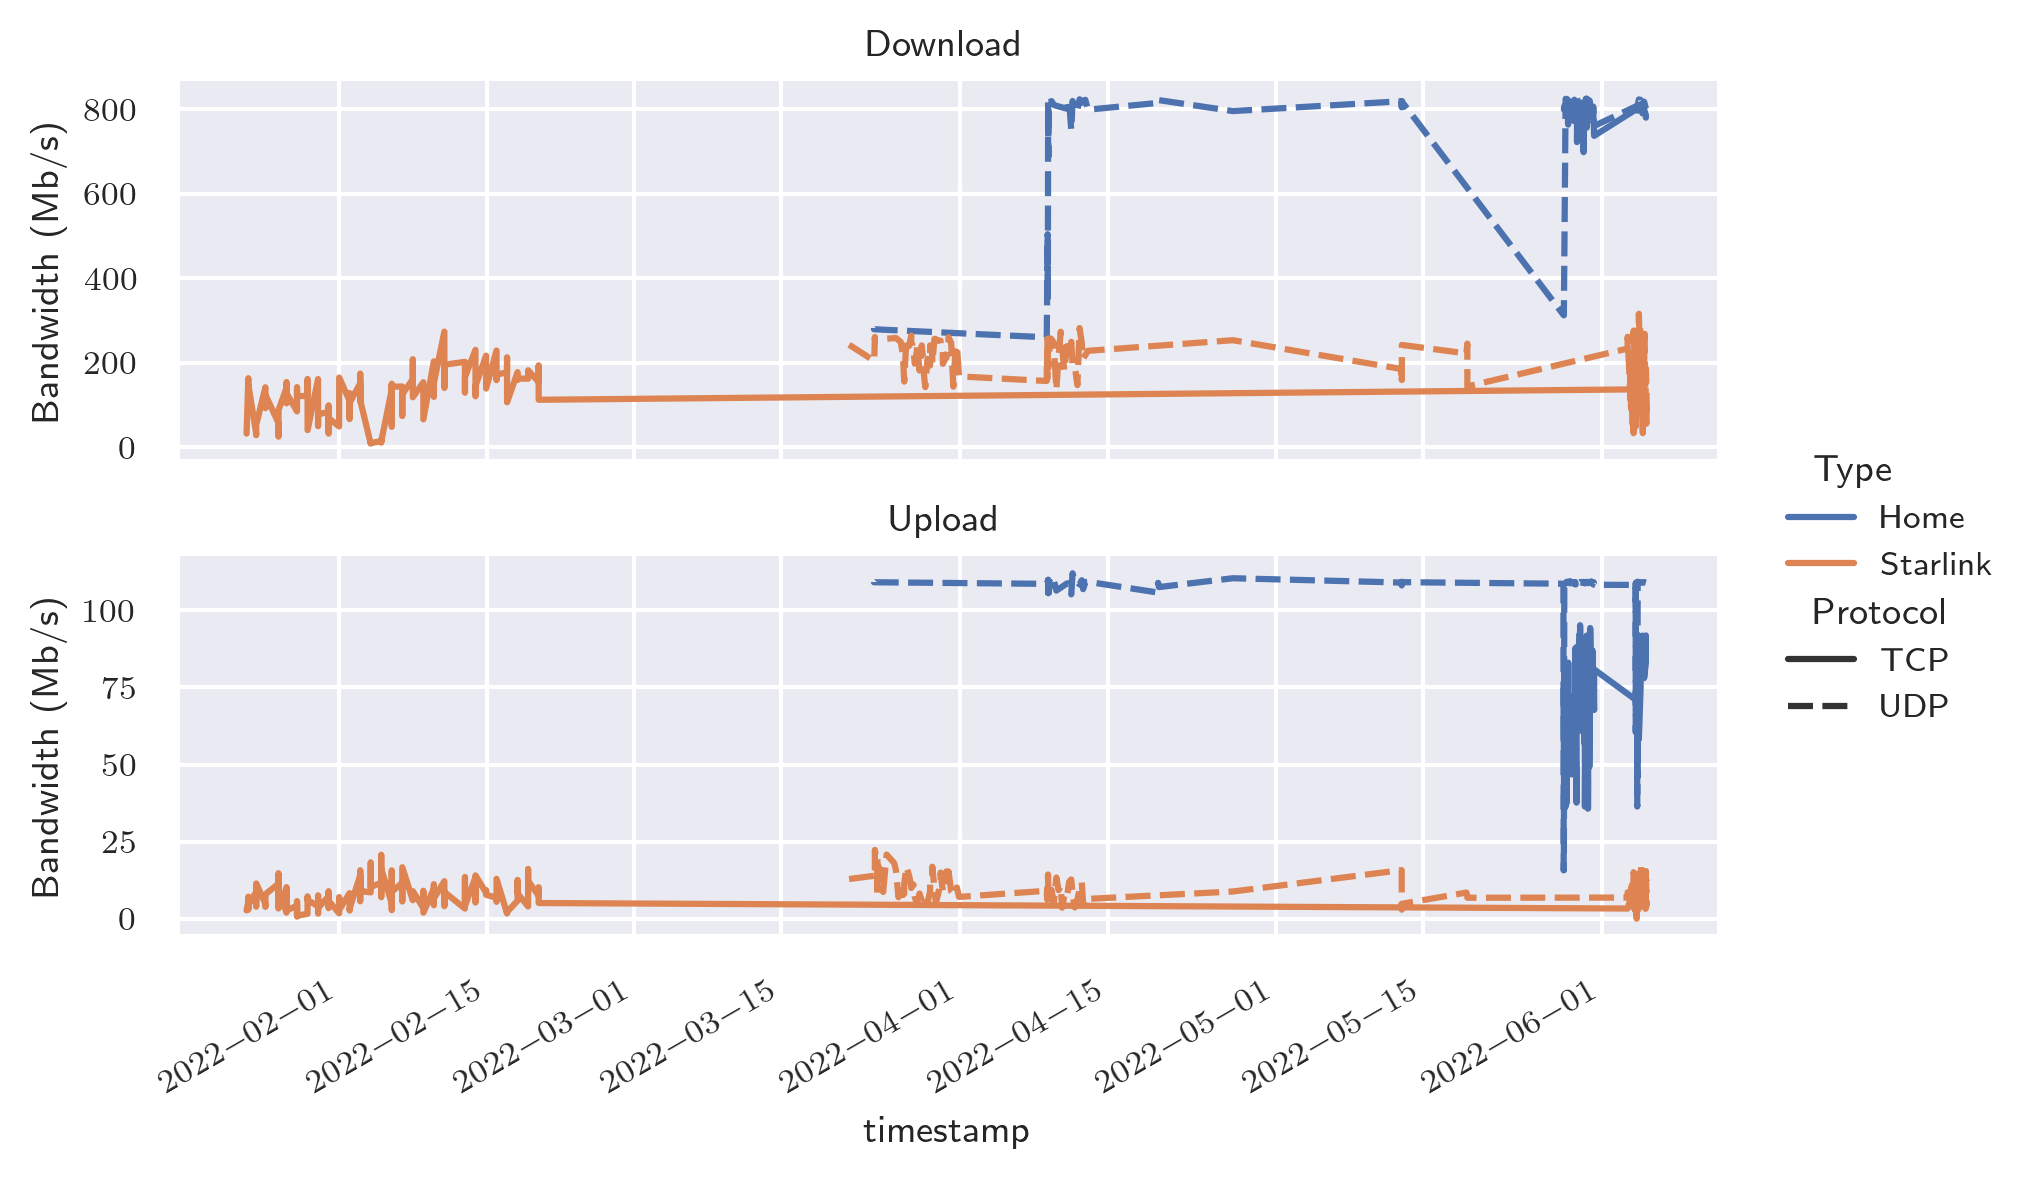

In [58]:
#fig, ax = plt.subplots(figsize=(3.5,3))
#fig, ax = plt.subplots(figsize=(20,10))

#ax.xaxis.update_units(df.index)
#y_val = df_unstacked.bandwidth
#sns.scatterplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)
#sns.jointplot(x=ax.xaxis.convert_units(df.timestamp), y=y_val, ax=ax)

#sns.lineplot(x=ax.xaxis.convert_units(df.index), y=y_val, ax=ax, hue=y_val.isna().cumsum(),
#        palette=["black"]*sum(y_val.isna()), markers=True, legend=False)
#sns.lineplot(data=df_regs)

temp = df_regs_interp
temp = temp.fillna(np.inf)
#temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_REGIONS] == 'N. California']
#g = sns.relplot(data=temp, row=COL_TRANSF_DIR, hue=N_REGIONS,
#                style=COL_PROT_TYPE, style_order=PROT_TYPE_ORDER,
#                height=2, aspect=2.98,
#                kind='line',
#                x = 'timestamp', y='bandwidth',
#                facet_kws={'sharey': False})

g = sns.relplot(data=temp, row=COL_TRANSF_DIR, hue=N_TYPE,
                style=N_PROTOCOL,
                height=2, aspect=2.98,
                kind='line',
                x = 'timestamp', y='bandwidth',
                facet_kws={'sharey': False})

#g_ax = g.fig.axes
#sns.scatterplot(data=df_outage, ax=g_ax)


#g = sns.lineplot(data=df_unstacked, x='timestamp', y='bandwidth', hue=N_REGIONS, style=N_TYPE)
#g = sns.lineplot(data=df_unstacked, x=df_unstacked.index, y='bandwidth')
#ax.set(yscale='log')

g.figure.autofmt_xdate()

#ax.set_ylabel("Jitter (ms)")
g.set_titles(row_template="{row_name}")
g.set(ylabel="Bandwidth (Mb/s)")
#g.set(yscale="log")
g.tight_layout()
#fig.tight_layout()

In [136]:
df_star = df_regs[df_regs[N_TYPE] == N_STARLINK]
df_star[df_star[N_PROTOCOL] == N_TCP].sort_values('timestamp')
#df_regs_interp.sort_values('timestamp')

,timestamp,bandwidth,jitter_ms,lost_packets,packets,lost_percent,Regions,Protocol,Transfer Direction,Type,Protocol and Type
97058,2022-01-23 04:35:16.000116224,8.918949,NaN,NaN,NaN,NaN,Sydney,TCP,Upload,Starlink,TCP Starlink
131372,2022-01-23 04:35:16.000148992,15.578690,NaN,NaN,NaN,NaN,Sydney,TCP,Download,Starlink,TCP Starlink
98171,2022-01-23 04:35:17.000197888,9.353438,NaN,NaN,NaN,NaN,Sydney,TCP,Upload,Starlink,TCP Starlink
141419,2022-01-23 04:35:17.000263936,19.361028,NaN,NaN,NaN,NaN,Sydney,TCP,Download,Starlink,TCP Starlink
146501,2022-01-23 04:35:18.000048896,23.225289,NaN,NaN,NaN,NaN,Sydney,TCP,Download,Starlink,TCP Starlink
...,...,...,...,...,...,...,...,...,...,...,...
11793,2022-06-05 05:14:27.000739072,0.000000,NaN,NaN,NaN,NaN,Cape Town,TCP,Upload,Starlink,TCP Starlink
222200,2022-06-05 05:14:28.000099840,92.677458,NaN,NaN,NaN,NaN,Cape Town,TCP,Download,Starlink,TCP Starlink
18791,2022-06-05 05:14:28.001073152,1.564906,NaN,NaN,NaN,NaN,Cape Town,TCP,Upload,Starlink,TCP Starlink
213915,2022-06-05 05:14:29.000040960,85.148361,NaN,NaN,NaN,NaN,Cape Town,TCP,Download,Starlink,TCP Starlink


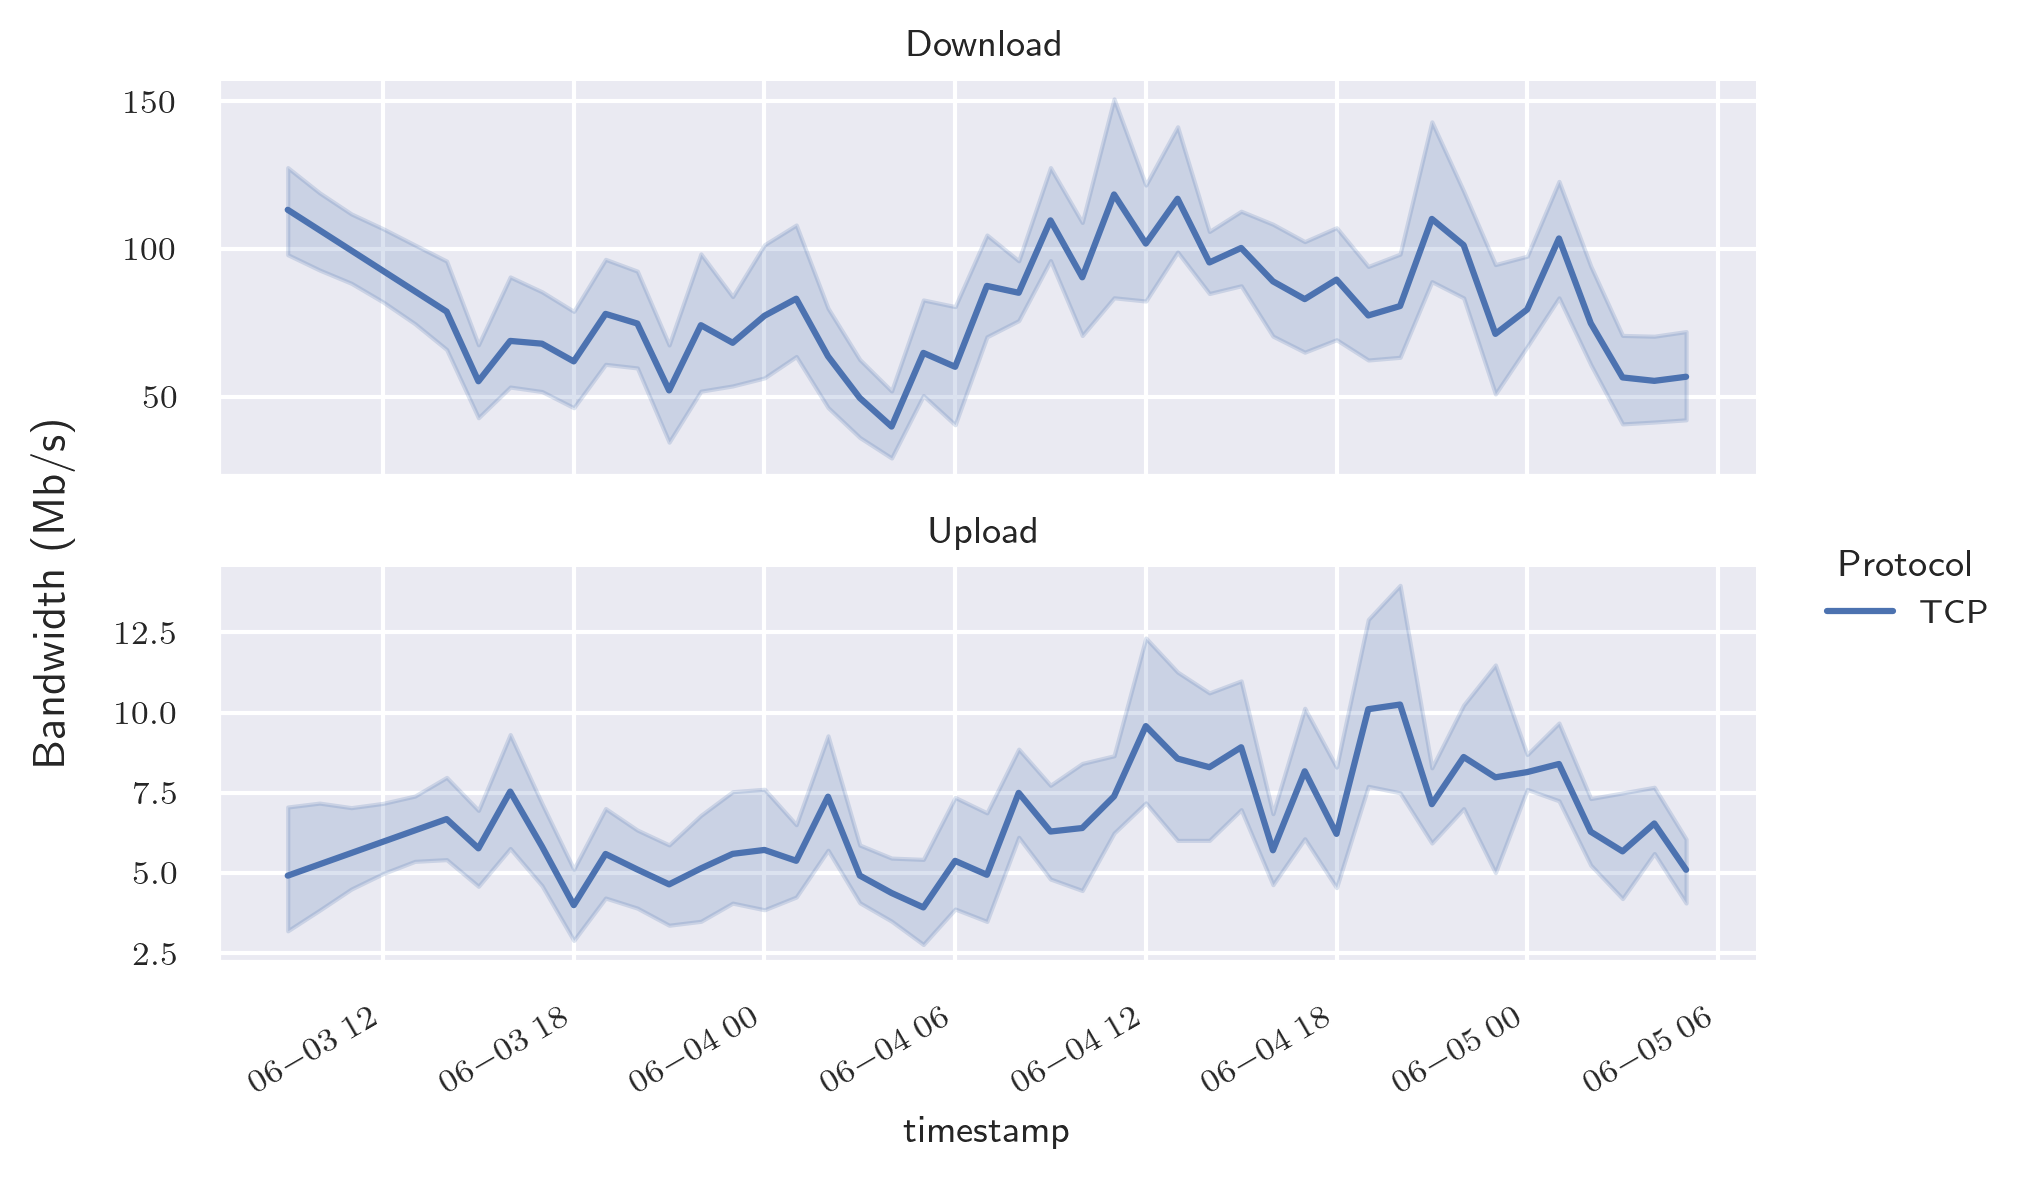

In [68]:
temp = df_regs_interp.copy()
temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_TYPE] == N_STARLINK]
temp = temp[temp[N_PROTOCOL] == N_TCP]
temp['Day'] = temp.timestamp.dt.day

g_pat = sns.relplot(data=temp, row=COL_TRANSF_DIR,
                    hue=N_PROTOCOL,# style=N_PROTOCOL,
                    height=2, aspect=3.045,
                    kind='line',
                    x='timestamp', y='bandwidth',
                    facet_kws={'sharey': False})

g_pat.figure.autofmt_xdate()

g_pat.set_titles(row_template="{row_name}")
g_pat.set(ylabel="")
g_pat.figure.supylabel('Bandwidth (Mb/s)')
g_pat.tight_layout()

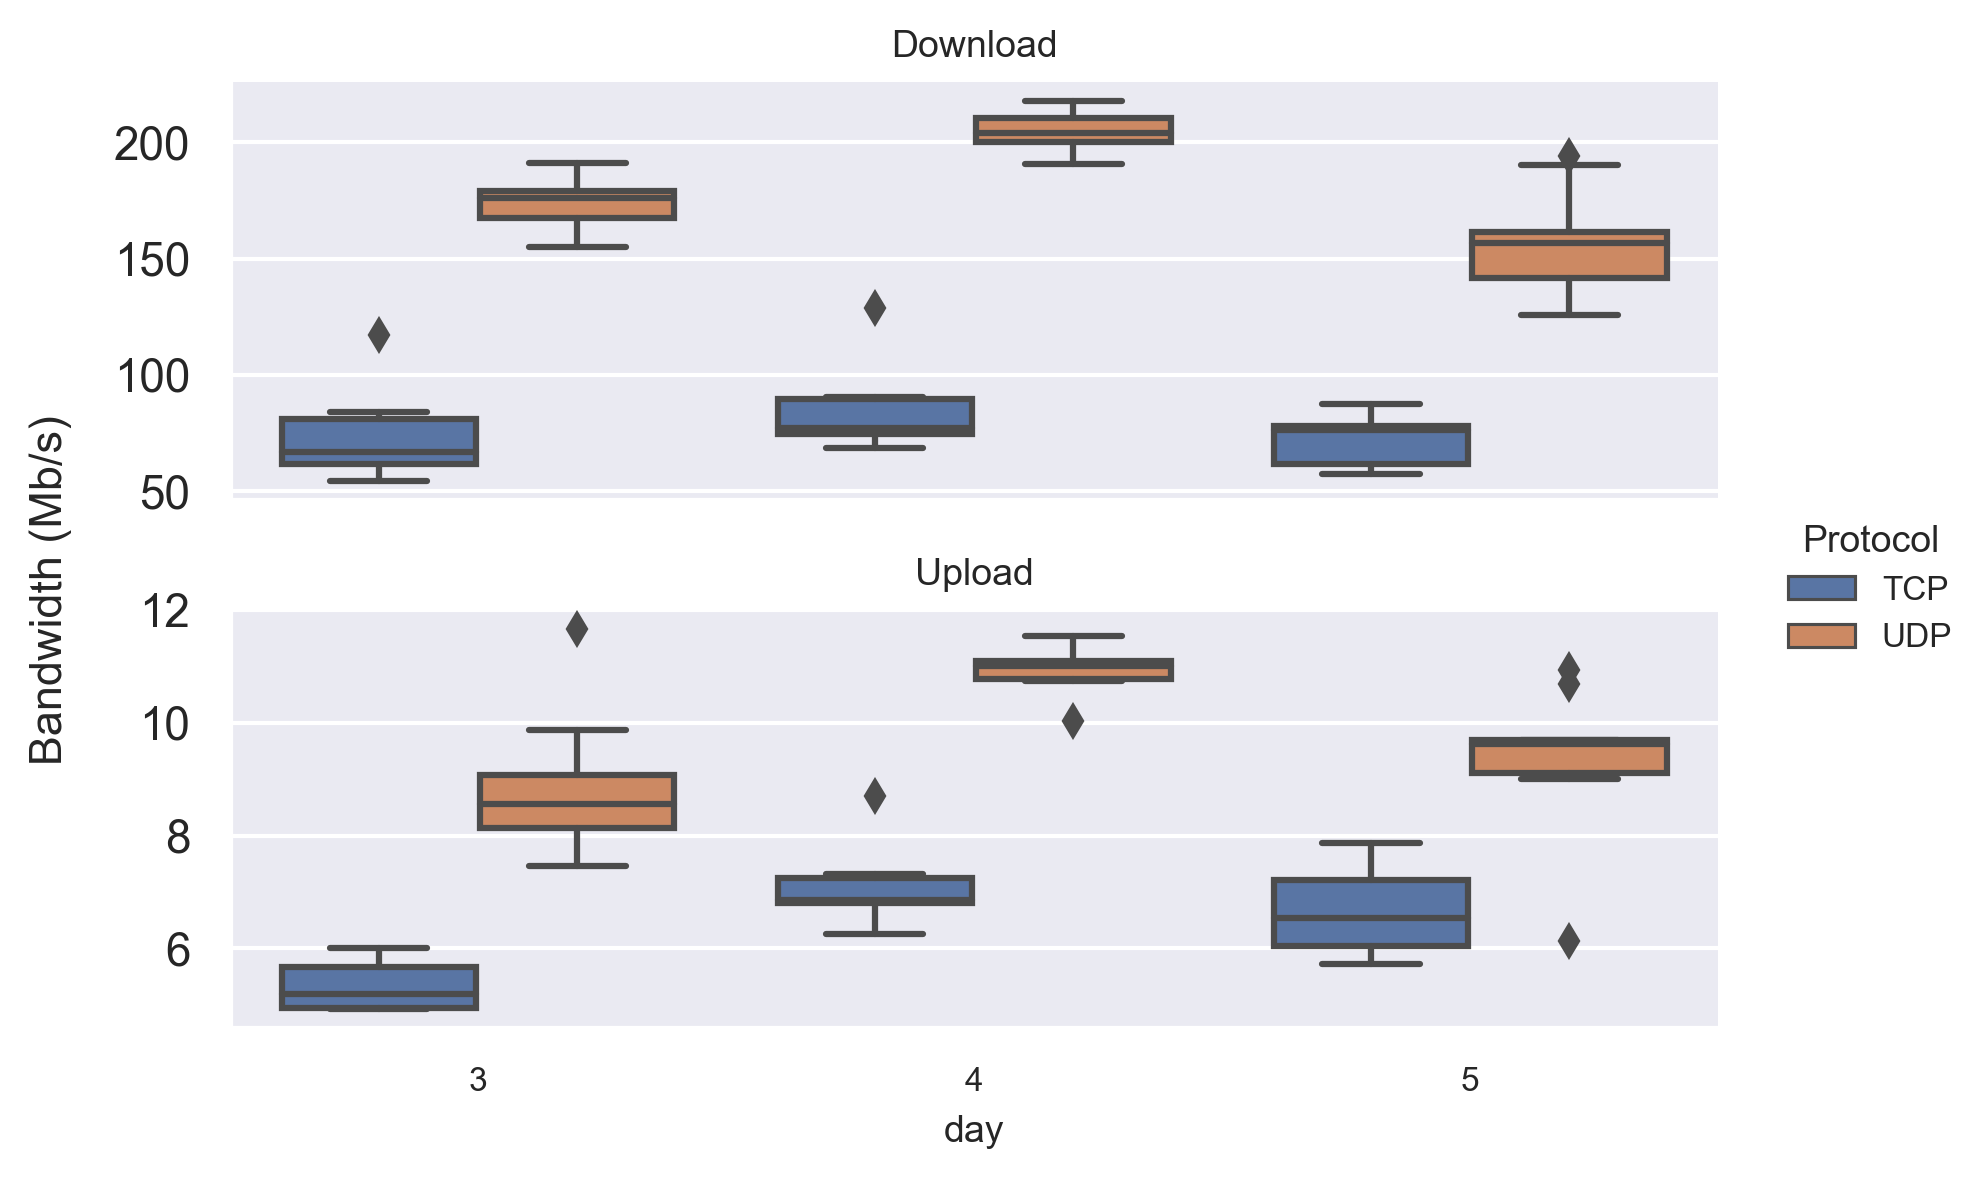

In [80]:
temp = df_regs_interp
temp = temp[temp['timestamp'] > '2022-06-02']
temp = temp[temp[N_TYPE] == N_STARLINK]
temp['day'] = temp.timestamp.dt.day

g_pat = sns.catplot(data=temp, row=COL_TRANSF_DIR,
                    hue=N_PROTOCOL,# style=N_PROTOCOL,
                    height=2, aspect=2.98,
                    kind='box', sharey=False,
                    x='day', y='bandwidth')

#g_pat.figure.autofmt_xdate()

g_pat.set_titles(row_template="{row_name}")
g_pat.set(ylabel="")
g_pat.figure.supylabel('Bandwidth (Mb/s)')
g_pat.tight_layout()

In [ ]:
from matplotlib.patches import Rectangle
g_bar = sns.catplot(data=df_regs,
                    col=N_PROTOCOL,
                    x=N_REGIONS, y='bandwidth',hue=N_TYPE,
                    ci='sd', 
                    kind='bar', legend=False,
                    height=2, aspect=1.79, col_wrap=2)

#g_bar.set_xticklabels(['TD', 'TU', 'UD', 'UU'])
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
g_bar.figure.autofmt_xdate()
g_bar.set_titles(col_template="{col_name}")
g_bar.axes.flatten()[1].legend()
#g_bar.add_legend(loc='upper right')
#g_bar.figure.legend([extra, extra, extra, extra], 
#                    ('TD = TCP Download','TU = TCP Upload', 
#                     'UD = UDP Download', 'UU = UDP Upload'),
#                   frameon=False, loc='lower right')
g_bar.set(ylabel="Bandwidth (Mb/s)")
g_bar.tight_layout()

In [165]:
g_bar.savefig(os.path.join(OUTPUT_FOLDER, 'throughput_summary.pgf'), bbox_inches='tight')

In [219]:
df_downs_only = df_regs[df_regs[N_PROTOCOL].isin([TCP_DOWN, UDP_DOWN])]
df_downs_only[df_downs_only[[N_PROTOCOL, N_REGIONS]].agg('-'.join, axis=1)

0                TCP Down-Mumbai
1                TCP Down-Sydney
2                TCP Down-Sydney
3                TCP Down-Sydney
4                TCP Down-Sydney
                   ...          
112355    UDP Down-N. California
112356    UDP Down-N. California
112357    UDP Down-N. California
112358    UDP Down-N. California
112359    UDP Down-N. California
Length: 73091, dtype: object

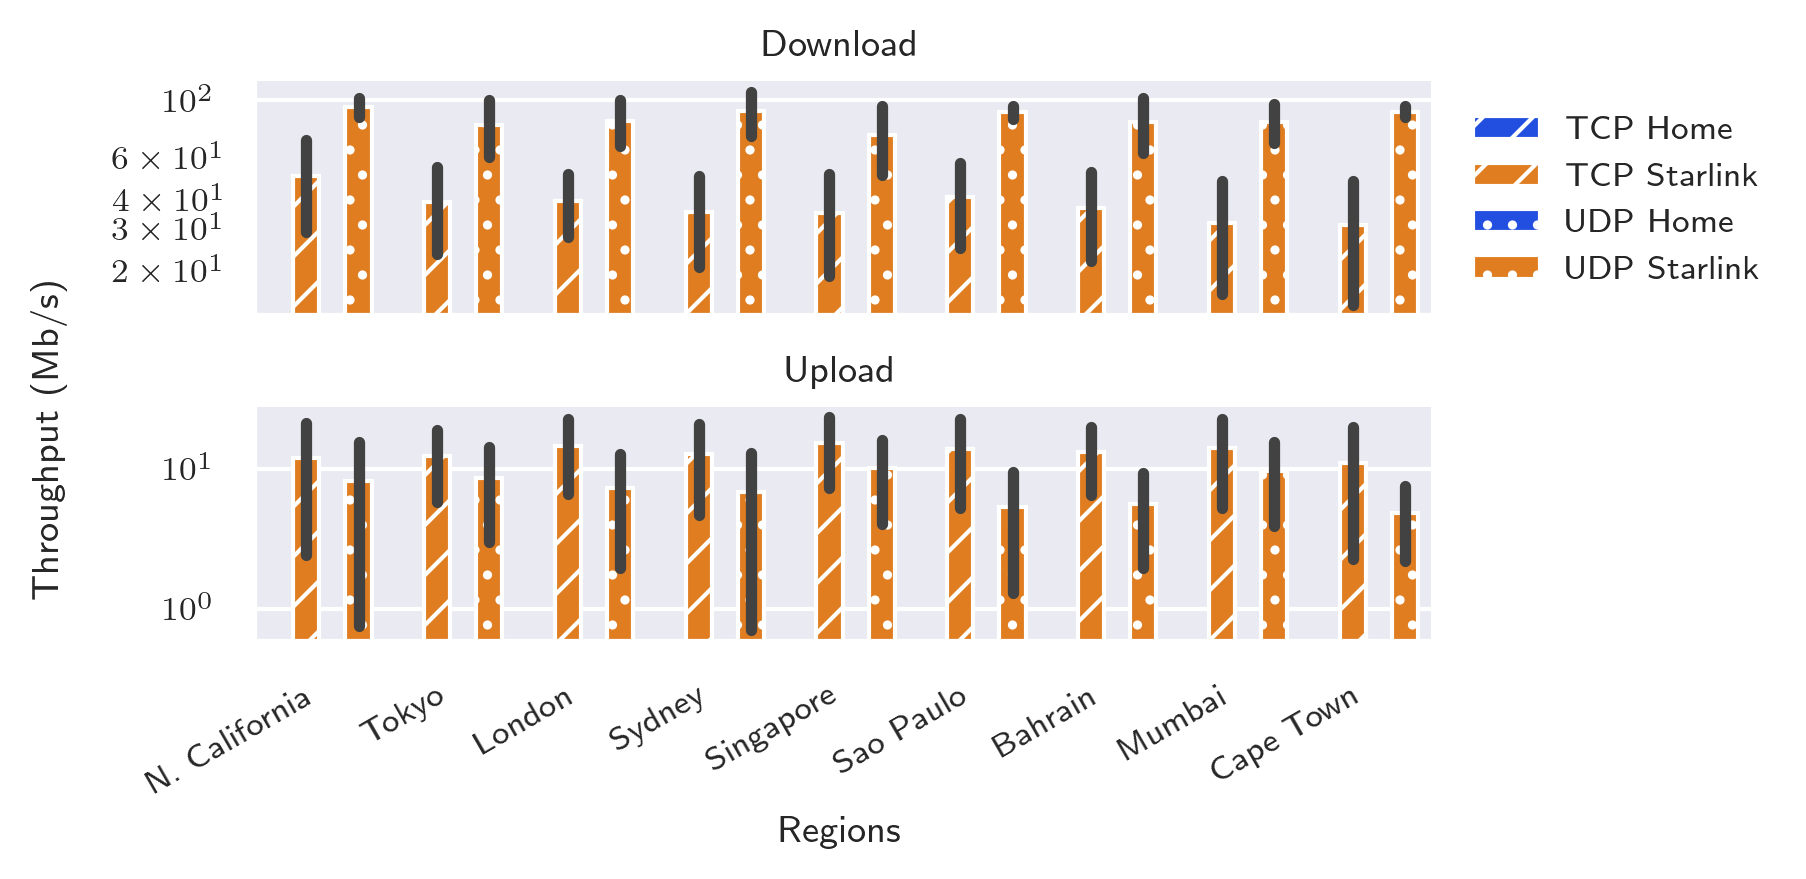

In [127]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('bright')
g_avg = sns.catplot(data=df_regs,
                    row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_REGIONS, y='bandwidth', hue=COL_PROT_TYPE,
                    hue_order=PROT_TYPE_ORDER, row_order=[N_DOWN, N_UP],
                    order=common.REGION_ORDER,
                    legend=False,
                    palette=['C0', 'C1', 'C0', 'C1'],
                    kind='bar', ci='sd',
                    height=1.5, aspect=4.06)

num_locs = len(df_regs[N_REGIONS].unique())
hatches = itertools.cycle(['//','//', '..', '..'])
axes = g_avg.axes.flatten()
for ax in axes:
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
            colour = next(colours)
        bar.set_hatch(hatch)
        #print(bar.get_facecolor())
        #bar.set_color(colour)

axes[0].legend(loc='lower left', bbox_to_anchor=(1.01,0), fancybox=True, frameon=False)
g_avg.figure.autofmt_xdate()
g_avg.set_titles(row_template="{row_name}")
g_avg.set(ylabel="")
g_avg.figure.supylabel("Throughput (Mb/s)", fontsize=9)
g_avg.tight_layout()

In [109]:
g_avg.savefig(os.path.join(OUTPUT_FOLDER, 'throughput_summary.pdf'), bbox_inches='tight')

In [137]:
df_regs_all  = df_regs
#df_regs_all[N_TYPE] = df_regs[N_TYPE].map({N_STARLINK: N_STARLINK_KOEYE})
df_regs_all = pd.concat([df_regs_all, df_regs_old])
df_regs_all

,timestamp,bandwidth,Regions,Protocol,Transfer Direction,Type,Protocol and Type,jitter_ms,lost_packets,packets,lost_percent
0,2022-05-23 03:04:15.001032960,0.000000,Singapore,UDP,Upload,Starlink Koeye,UDP Starlink,0.000000,0.0,0.0,0.000000
1,2022-05-23 08:05:32.000901888,0.000000,Tokyo,UDP,Upload,Starlink Koeye,UDP Starlink,0.000000,0.0,0.0,0.000000
2,2022-05-23 08:05:33.001037056,0.000000,Tokyo,UDP,Upload,Starlink Koeye,UDP Starlink,0.000000,0.0,0.0,0.000000
3,2022-05-22 14:39:48.000000000,0.000000,N. California,UDP,Upload,Starlink Koeye,UDP Starlink,0.000000,0.0,0.0,0.000000
4,2022-05-22 14:39:49.000086016,0.000000,N. California,UDP,Upload,Starlink Koeye,UDP Starlink,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
361845,2022-05-28 22:09:51.000088832,836.142764,N. California,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN
361846,2022-05-29 14:10:28.000004096,838.120572,N. California,UDP,Download,Home,UDP Home,0.070071,617.0,72969.0,0.845565
361847,2022-05-28 10:01:02.000055040,838.443014,Sydney,UDP,Download,Home,UDP Home,0.055429,793.0,73169.0,1.083792
361848,2022-05-30 17:09:39.000015104,842.372040,N. California,TCP,Download,Home,TCP Home,NaN,NaN,NaN,NaN


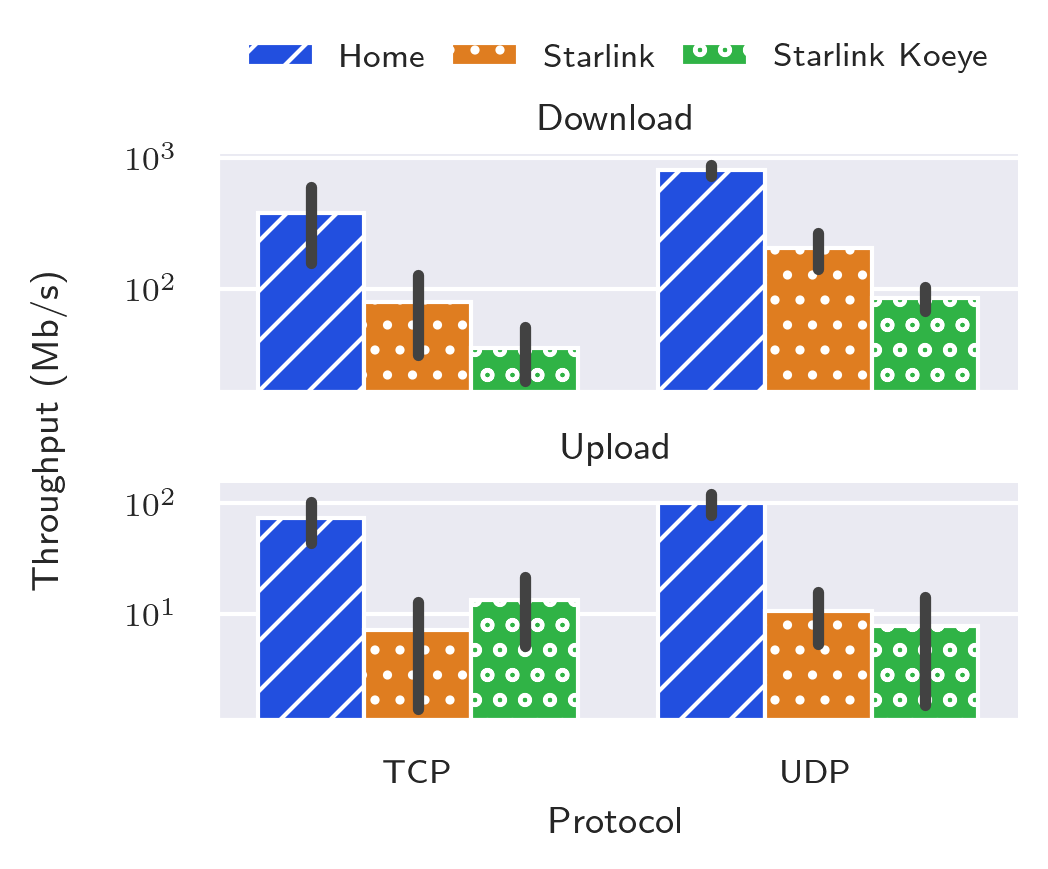

In [181]:
#temp = df_regs.loc['2022-06-03':]
sns.set_palette('bright')
g_avg_small = sns.catplot(data=df_regs_all, row=COL_TRANSF_DIR,
                    sharey=False, log=True,
                    x=N_PROTOCOL, y='bandwidth', hue=N_TYPE,
                    hue_order=[N_HOME, N_STARLINK, N_STARLINK_KOEYE],
                    order=[N_TCP, N_UDP], row_order=[N_DOWN, N_UP],
                    legend=False,
                    kind='bar', ci='sd',
                    height=1.5, aspect=2.3333)

num_locs = len(df_regs[N_PROTOCOL].unique())
hatches = itertools.cycle(['//','..', 'oo'])
axes = g_avg_small.axes.flatten()
for ax in axes:
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

#axes[0].legend(loc='lower left', bbox_to_anchor=(1.01,0), fancybox=True, frameon=False)
axes[0].legend(loc='lower left', bbox_to_anchor=(0,1.22,1,0.2), ncol=3, mode='expand', fancybox=True, frameon=False)
#axes[0].legend(loc='lower left', bbox_to_anchor=(0,1.02,1,0.2), mode='expand', ncol=3, fancybox=True, frameon=False)
#g_avg_small.figure.autofmt_xdate()
g_avg_small.set_titles(row_template="{row_name}")
g_avg_small.set(ylabel="")
g_avg_small.figure.supylabel("Throughput (Mb/s)", fontsize=9)
g_avg_small.tight_layout()

In [182]:
g_avg_small.savefig(os.path.join(OUTPUT_FOLDER, 'throughput_koeye_summary.pdf'), bbox_inches='tight')

In [13]:
sns.plotting_context()

{'font.size': 9.0,
 'axes.labelsize': 9.0,
 'axes.titlesize': 9.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.8,
 'legend.fontsize': 8.0,
 'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.2000000000000002,
 'lines.markersize': 4.800000000000001,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.800000000000001,
 'ytick.major.size': 4.800000000000001,
 'xtick.minor.size': 3.2,
 'ytick.minor.size': 3.2,
 'legend.title_fontsize': 9.0}

In [29]:
def diff_table(table):
    df_perc = table.pivot_table(index=[N_PROTOCOL, N_REGIONS], columns=N_TYPE, values='bandwidth')
    df_perc['diff'] = df_perc['Home'] - df_perc['Starlink']
    return df_perc.reset_index().pivot_table(index=N_PROTOCOL, columns=N_REGIONS, values='diff')

#diff_table(df_regs)
#diff_table(df_regs.groupby([N_TYPE, N_PROTOCOL, N_REGIONS]).mean().reset_index())

#df_agg = df_regs.groupby([N_TYPE, N_PROTOCOL, N_REGIONS]).max().reset_index()

#df_agg.pivot_table(index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL], values='bandwidth')
#df_agg = df_regs[df_regs[N_TYPE] == N_STARLINK]
#df_agg = df_agg[df_agg[COL_TRANSF_DIR] == N_DOWN]
#df_agg = df_agg[df_agg[N_PROTOCOL] == N_UDP]
#df_agg = df_agg[df_agg['lost_percent'] == 0]
#df_agg[df_agg['bandwidth'] < 200]

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Protocol,,,,,,,,,
TCP,185.522191,149.177327,299.328687,163.080643,371.702437,225.167185,220.874687,117.946149,299.002705
UDP,302.338865,321.911059,299.337305,295.839713,308.140715,304.474719,281.216713,260.982379,278.296849


In [192]:
df_avg = df_outliers[df_outliers['bandwidth'] > 0]
df_avg = df_avg[df_avg[N_THROUGHPUT_OUTLIERS] == False]
df_avg = df_regs.pivot_table(index=N_REGIONS, columns=[N_TYPE, N_PROTOCOL, COL_TRANSF_DIR], values='bandwidth', aggfunc='count').reindex(common.REGION_ORDER)
#df_avg = df_regs_all.pivot_table(index=COL_TRANSF_DIR, columns=[N_TYPE, N_PROTOCOL], values='bandwidth')
#styler = df_avg.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, 'all_bandwidth.tex'))
df_avg
#df_scale = pd.DataFrame()
#df_scale[N_TCP] = df_avg[N_STARLINK_KOEYE][N_TCP] / df_avg[N_STARLINK][N_TCP]
#df_scale[N_UDP] = df_avg[N_STARLINK_KOEYE][N_UDP] / df_avg[N_STARLINK][N_UDP]
#df_scale

Type               Starlink Koeye                       
Protocol                      TCP             UDP       
Transfer Direction       Download Upload Download Upload
Regions                                                 
N. California                 339    417      916   2955
Tokyo                         525    581      441    782
London                        529    529      463    790
Sydney                        607    607     1187   1576
Singapore                     499    593      428    744
Sao Paulo                     391    417      360    474
Bahrain                       473    473      439    436
Mumbai                        503    529      372   1025
Cape Town                     417    417      343    469

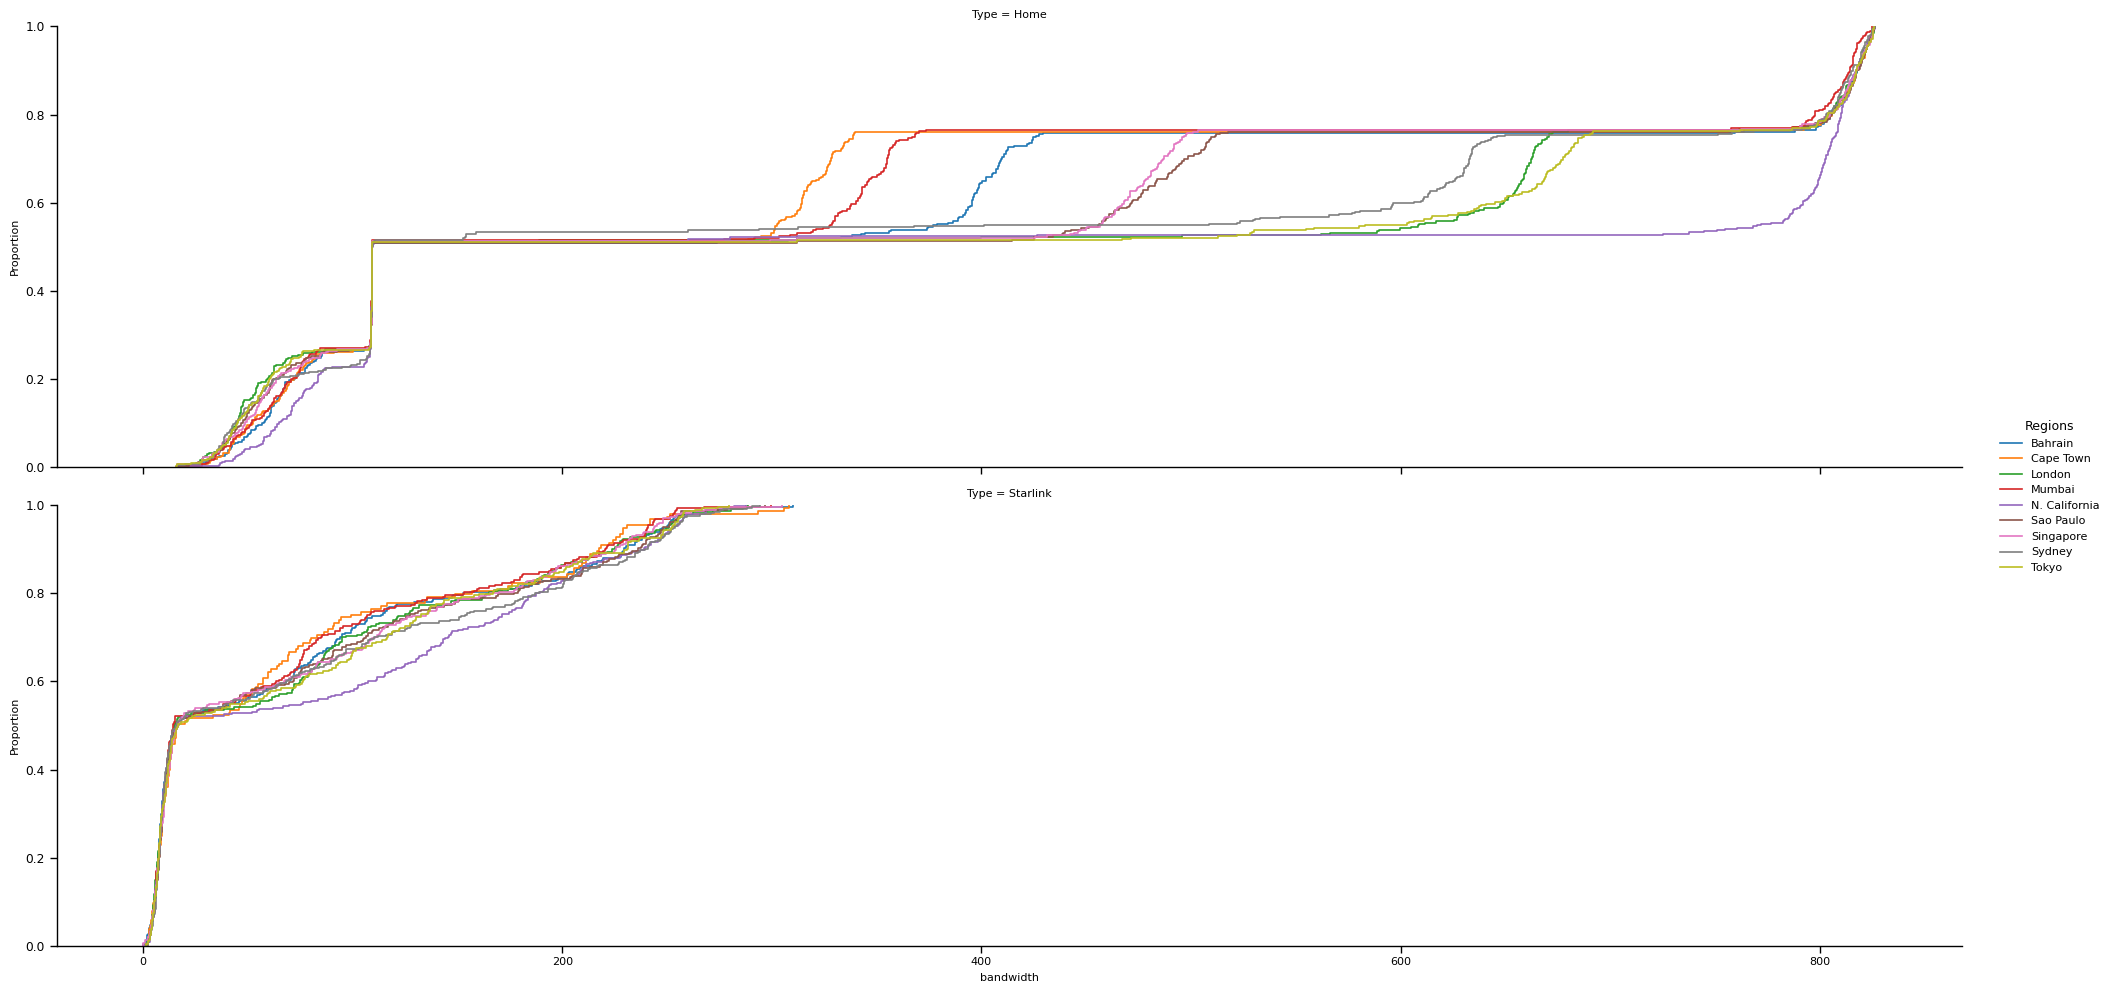

In [135]:
#fig2, ax2 = plt.subplots(figsize=(20,10))
g2 = sns.FacetGrid(data=df_unstacked, row=N_TYPE, hue=N_REGIONS, height=5, aspect=4)
g2.map(sns.ecdfplot, 'bandwidth')
g2.add_legend()
g2.tight_layout()
#fig2.tight_layout()

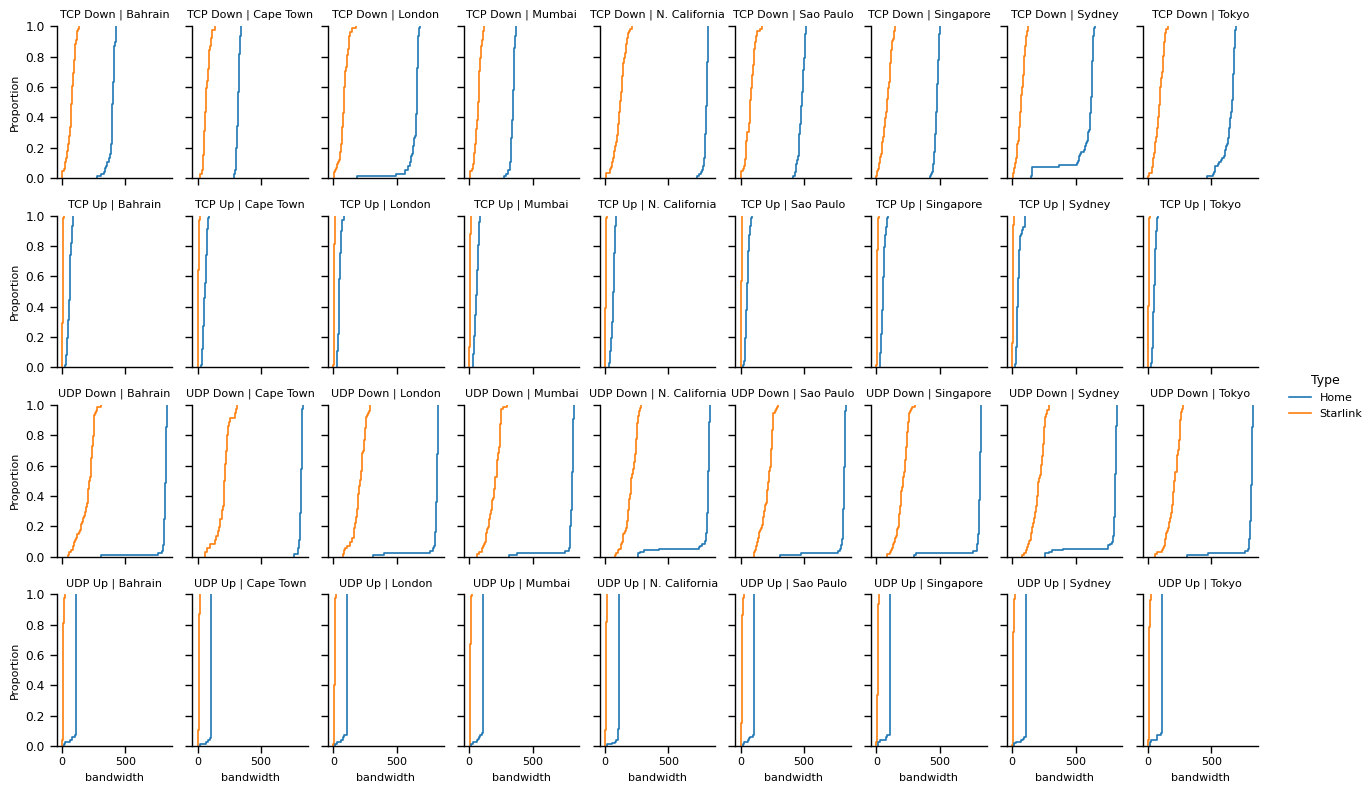

In [136]:
g_hist = sns.displot(
    data=df_unstacked, 
    x='bandwidth', col=N_REGIONS, row=N_PROTOCOL, hue=N_TYPE, kind='ecdf', height=2, aspect=0.716)
g_hist.set_titles(col_template="{col_name}", row_template="{row_name}")
g_hist.tight_layout()

In [150]:
g.savefig(f'output/throughput/throughput.pdf', bbox_inches='tight')
g2.savefig(f'output/throughput/throughput_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'output/throughput/throughput.png', bbox_inches='tight')
#fig2.savefig(f'output/throughput/throughput_cdf.png', bbox_inches='tight')